# Análisis y Predicción de Ventas con Prophet y LSTM

En este Notebook, realizamos un análisis exploratorio de un dataset de ventas
y construimos diferentes modelos de predicción (Prophet y LSTM). Nuestro objetivo
es determinar cuál modelo ofrece la mejor precisión y extraer recomendaciones
para el negocio.


In [4]:
import pandas as pd


In [5]:
df = pd.read_csv("train.csv")

In [6]:
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


## Carga de Datos

El dataset se compone de las siguientes columnas:
- **date**: fecha de la venta
- **store**: identificador de la tienda
- **item**: identificador del producto
- **sales**: ventas totales en esa tienda-producto-fecha


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [8]:
df.isna().sum()

,0
date,0
store,0
item,0
sales,0


In [9]:
import numpy as np
from scipy.stats import zscore

# Método 1: IQR (Tukey)
Q1 = df["sales"].quantile(0.25)
Q3 = df["sales"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df["Outlier_IQR"] = (df["sales"] < lower_bound) | (df["sales"] > upper_bound)

# Método 2: Z-Score
df["Z_Score"] = np.abs(zscore(df["sales"]))
df["Outlier_Z_Score"] = df["Z_Score"] > 3  # Consideramos outliers valores con Z > 3

# Mostrar los outliers detectados
outliers = df[df["Outlier_IQR"] | df["Outlier_Z_Score"]]
print(outliers[["date", "store", "item", "sales", "Outlier_IQR", "Outlier_Z_Score"]])


              date  store  item  sales  Outlier_IQR  Outlier_Z_Score
21330   2016-05-29      2     2    139         True             True
21344   2016-06-12      2     2    131         True            False
21365   2016-07-03      2     2    138         True            False
21372   2016-07-10      2     2    134         True            False
21399   2016-08-06      2     2    136         True            False
...            ...    ...   ...    ...          ...              ...
912796  2017-06-11     10    50    137         True            False
912803  2017-06-18     10    50    150         True             True
912824  2017-07-09     10    50    135         True            False
912831  2017-07-16     10    50    143         True             True
912838  2017-07-23     10    50    140         True             True

[11967 rows x 6 columns]


### Limpieza de Datos
Verificamos valores nulos y convertimos la columna 'date' a formato datetime.
Luego, detectamos outliers en la variable 'sales' usando el método IQR y
decidimos conservarlos, ya que pueden representar promociones o eventos especiales.


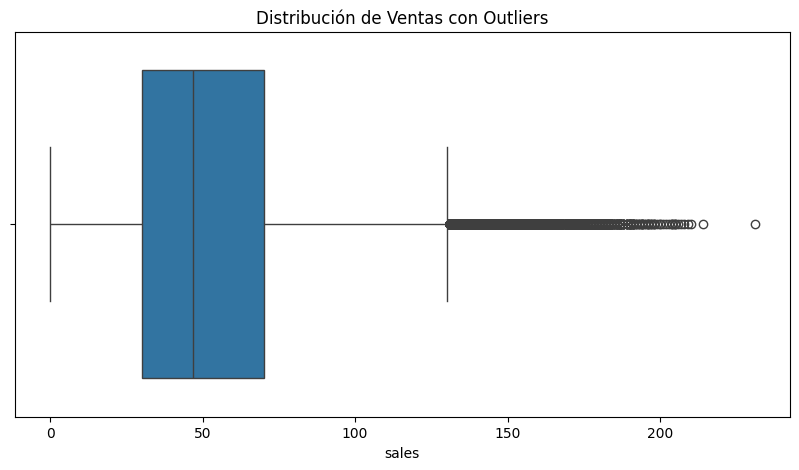

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=df["sales"])
plt.title("Distribución de Ventas con Outliers")
plt.show()


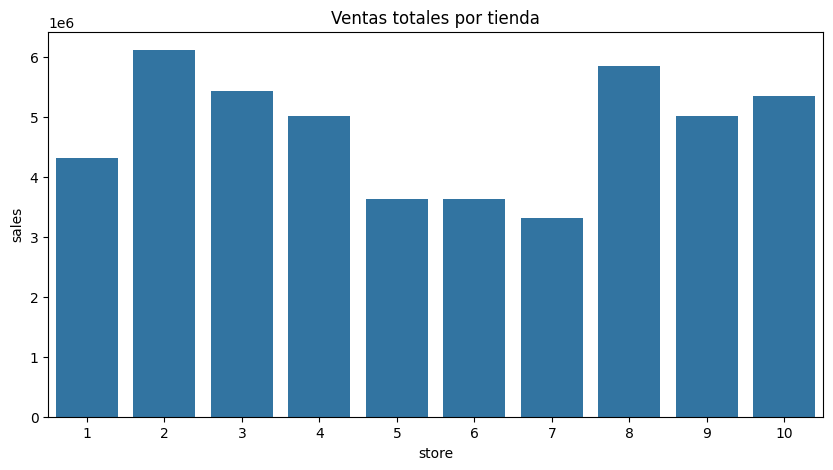

In [27]:
# Ventas por tienda
store_sales = df.groupby("store")["sales"].sum().reset_index()
plt.figure(figsize=(10,5))
sns.barplot(data=store_sales, x="store", y="sales")
plt.title("Ventas totales por tienda")
plt.show()


### 5.1 Distribución de Ventas
Observamos la forma de la distribución para identificar sesgos y posibles valores atípicos.


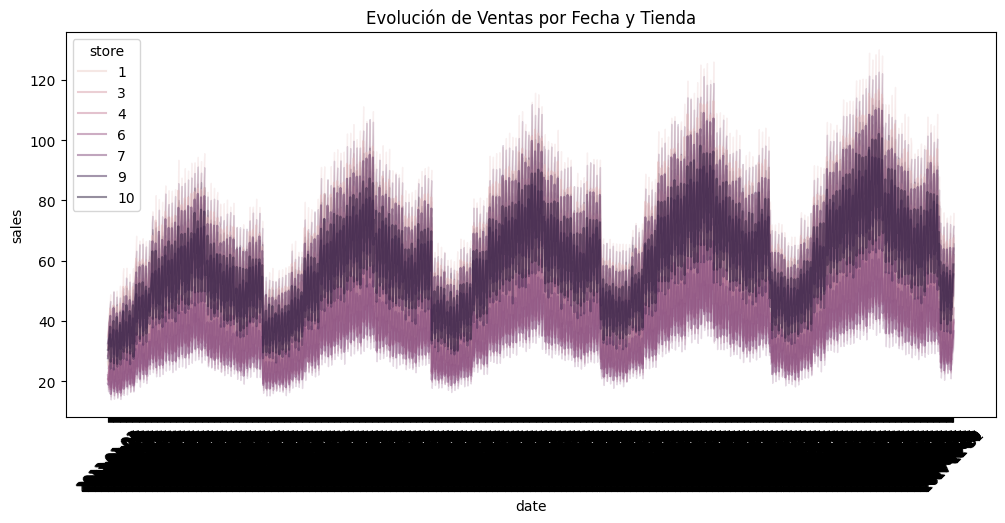

In [11]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x="date", y="sales", hue="store", alpha=0.5)
plt.xticks(rotation=45)
plt.title("Evolución de Ventas por Fecha y Tienda")
plt.show()


**Observación**: La distribución presenta una cola larga hacia la derecha, lo que sugiere
que hay días con ventas excepcionalmente altas.


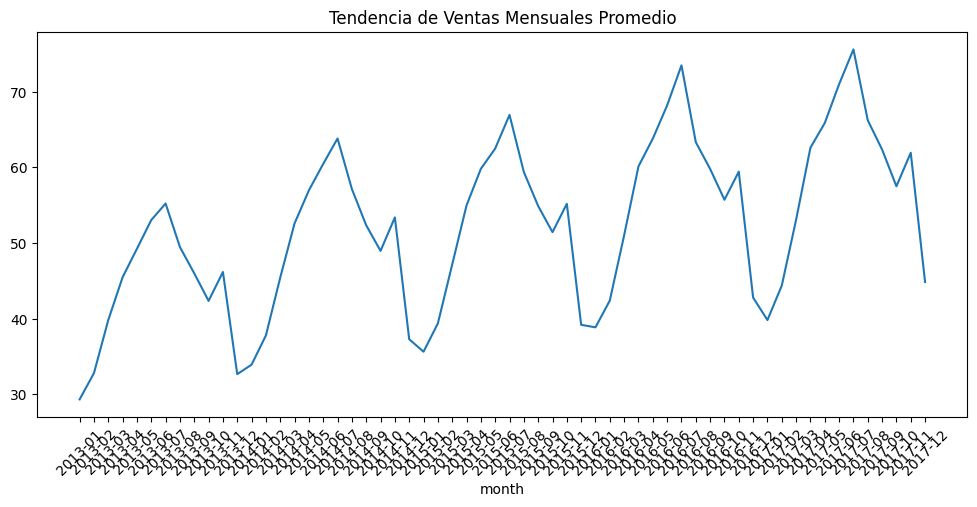

In [12]:
df["date"] = pd.to_datetime(df["date"])  # Convertimos a formato fecha
df["month"] = df["date"].dt.to_period("M")  # Extraemos el mes

monthly_sales = df.groupby("month")["sales"].mean()

plt.figure(figsize=(12, 5))
sns.lineplot(x=monthly_sales.index.astype(str), y=monthly_sales.values)
plt.xticks(rotation=45)
plt.title("Tendencia de Ventas Mensuales Promedio")
plt.show()


### 5.2 Tendencia en el Tiempo
Analizamos la serie temporal para detectar estacionalidad y tendencia.


**Observación**: Se aprecia una tendencia alcista con picos en ciertos meses del año.


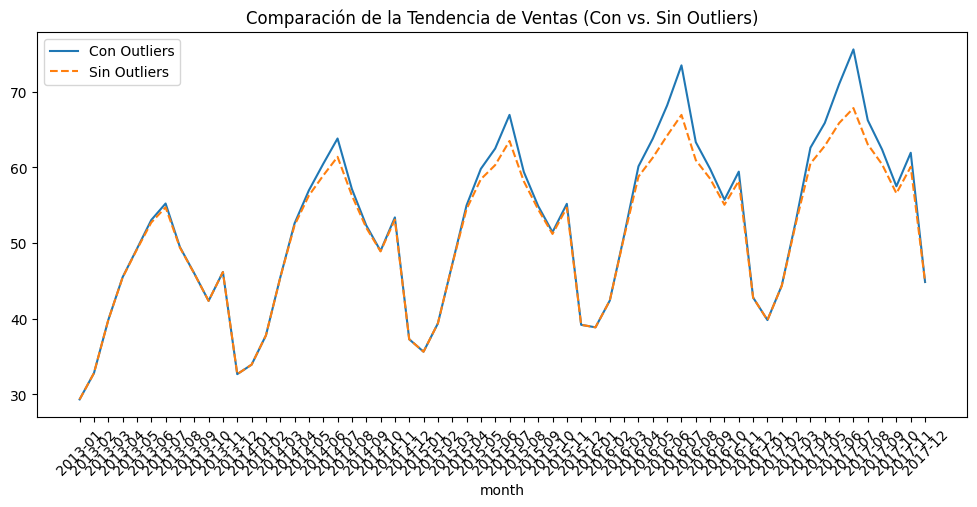

In [13]:
# Crear DataFrame sin outliers
df_clean = df[~(df["Outlier_IQR"] | df["Outlier_Z_Score"])]

# Calcular ventas promedio por mes para ambos datasets
monthly_sales_original = df.groupby("month")["sales"].mean()
monthly_sales_clean = df_clean.groupby("month")["sales"].mean()

plt.figure(figsize=(12, 5))
sns.lineplot(x=monthly_sales_original.index.astype(str), y=monthly_sales_original.values, label="Con Outliers")
sns.lineplot(x=monthly_sales_clean.index.astype(str), y=monthly_sales_clean.values, label="Sin Outliers", linestyle="dashed")
plt.xticks(rotation=45)
plt.title("Comparación de la Tendencia de Ventas (Con vs. Sin Outliers)")
plt.legend()
plt.show()


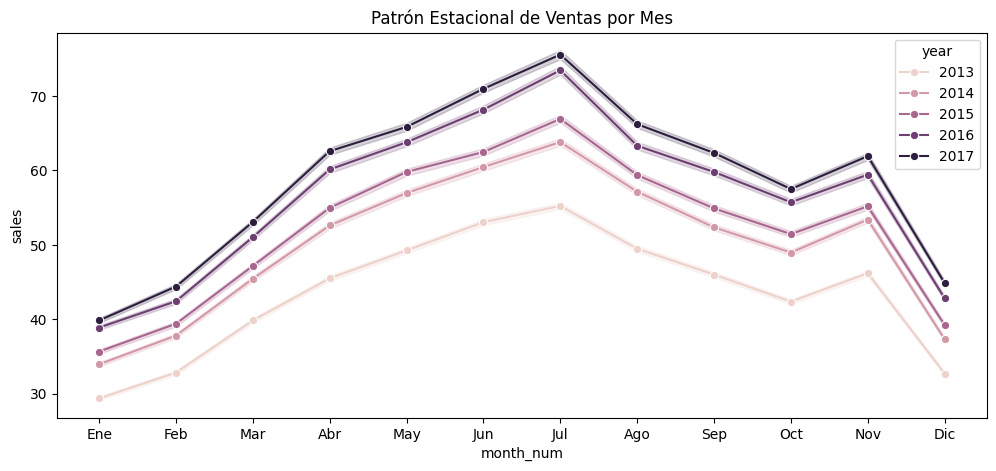

In [14]:
df["year"] = df["date"].dt.year
df["month_num"] = df["date"].dt.month

plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x="month_num", y="sales", hue="year", marker="o")
plt.xticks(range(1, 13), ["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"])
plt.title("Patrón Estacional de Ventas por Mes")
plt.show()


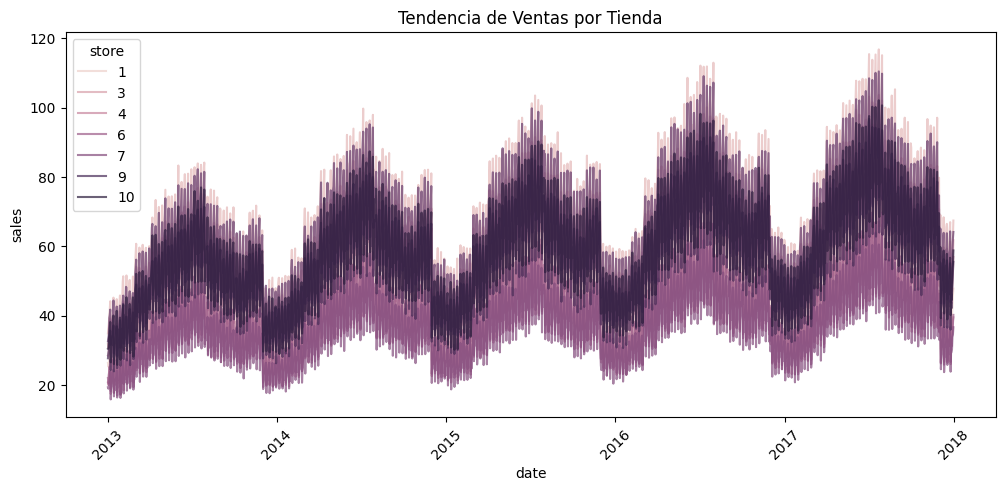

In [15]:
store_trend = df.groupby(["date", "store"])["sales"].mean().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=store_trend, x="date", y="sales", hue="store", alpha=0.7)
plt.xticks(rotation=45)
plt.title("Tendencia de Ventas por Tienda")
plt.show()


<ipython-input-16-56d498014d47>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df["sales"].resample("M").sum()  # Agrupar ventas por mes
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
<ipython-input-16-56d498014d47>:34: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=monthly_sales["date"].iloc[-1], periods=7, freq="M")[1:]


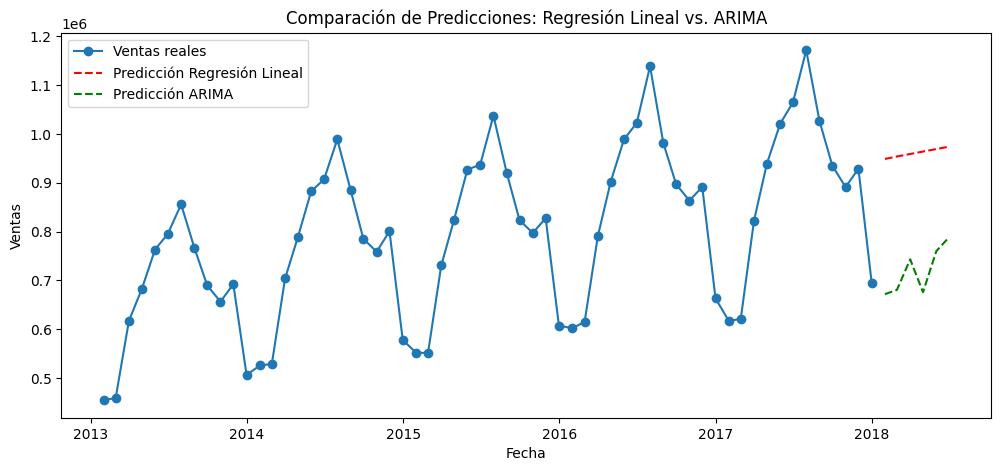

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA

# Convertir la columna de fecha a datetime y preparar datos
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)
monthly_sales = df["sales"].resample("M").sum()  # Agrupar ventas por mes

# Preparar datos para Regresión Lineal
monthly_sales = monthly_sales.reset_index()
monthly_sales["month_num"] = np.arange(len(monthly_sales))

# Dividir datos en X (meses) e y (ventas)
X = monthly_sales[["month_num"]]
y = monthly_sales["sales"]

# Modelo de Regresión Lineal
model_lr = LinearRegression()
model_lr.fit(X, y)

# Predicción para los próximos 6 meses con Regresión Lineal
future_months = np.arange(len(monthly_sales), len(monthly_sales) + 6).reshape(-1, 1)
predicted_lr = model_lr.predict(future_months)

# Modelo ARIMA
model_arima = ARIMA(monthly_sales["sales"], order=(5,1,0))  # Orden (p,d,q) a ajustar según los datos
model_fit = model_arima.fit()
future_arima = model_fit.forecast(steps=6)

# Crear eje de tiempo para predicciones
future_dates = pd.date_range(start=monthly_sales["date"].iloc[-1], periods=7, freq="M")[1:]

# Graficar
plt.figure(figsize=(12, 5))
plt.plot(monthly_sales["date"], monthly_sales["sales"], label="Ventas reales", marker="o")
plt.plot(future_dates, predicted_lr, "r--", label="Predicción Regresión Lineal")
plt.plot(future_dates, future_arima, "g--", label="Predicción ARIMA")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.title("Comparación de Predicciones: Regresión Lineal vs. ARIMA")
plt.legend()
plt.show()


In [17]:
! pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.0 MB/s eta 0:00:00


In [33]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ---------------------------
# 1. Preparar los datos
# ---------------------------
# Suponiendo que 'monthly_sales' es un DataFrame con una columna "sales"
# (por ejemplo, ventas mensuales agregadas).

# Ejemplo de split 80% entrenamiento, 20% test
train_size = int(len(monthly_sales) * 0.8)
train = monthly_sales["sales"][:train_size]
test = monthly_sales["sales"][train_size:]

# ---------------------------
# 2. Ajustar el modelo con auto_arima
# ---------------------------
# Si tus datos tienen estacionalidad mensual (por ejemplo, 12 meses),
# puedes usar seasonal=True, m=12.
# Si no hay estacionalidad clara, pon seasonal=False.
best_arima = auto_arima(
    train,
    start_p=0, start_q=0,
    max_p=5, max_q=5,       # Limites para buscar p y q
    seasonal=False,         # Cambia a True si sospechas estacionalidad
    m=1,                    # m=12 si es mensual con estacionalidad anual
    trace=True,             # Para ver la búsqueda en consola
    error_action='ignore',  # Ignorar errores si algún modelo no converge
    suppress_warnings=True,
    stepwise=True           # Método más rápido de búsqueda
)

# Imprimir el mejor modelo encontrado
print("Mejor orden ARIMA encontrada:", best_arima.order)

# Entrenar el mejor modelo ARIMA en los datos de entrenamiento
model_fit = best_arima.fit(train)

# ---------------------------
# 3. Predicción y Evaluación
# ---------------------------
# Predecir sobre el conjunto de prueba
n_periods = len(test)
predictions = model_fit.predict(n_periods=n_periods)

# Calcular métricas de error
mae_arima = mean_absolute_error(test, predictions)
rmse_arima = np.sqrt(mean_squared_error(test, predictions))
mape_arima = np.mean(np.abs((test - predictions) / test)) * 100

print(f"MAE (ARIMA): {mae_arima:.2f}")
print(f"RMSE (ARIMA): {rmse_arima:.2f}")
print(f"MAPE (ARIMA): {mape_arima:.2f}%")

# ---------------------------
# 4. Pronóstico Futuro (Opcional)
# ---------------------------
# Si deseas predecir 12 periodos futuros:
future_forecast = model_fit.predict(n_periods=12)
print("Predicción para los próximos 12 periodos:", future_forecast)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1441.547, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1252.222, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1412.659, Time=0.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1252.274, Time=0.28 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1252.834, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1253.851, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1248.150, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1292.370, Time=0.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1244.642, Time=0.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1240.473, Time=0.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=1242.343, Time=0.34 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1231.866, Time=0.58 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1247.648, Time=0.26 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=1233.501, Time=0.73 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1231.074, Time=4.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1231.454, Time=0.72 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=1232.051, Time=3.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=1224.815, Time=1.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1232.649, Time=0.68 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.49 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=1218.717, Time=0.88 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=1235.933, Time=0.33 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,4)(0,0,0)[0] intercept   : AIC=1217.392, Time=0.48 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,5)(0,0,0)[0] intercept   : AIC=inf, Time=1.29 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,5)(0,0,0)[0] intercept   : AIC=inf, Time=1.93 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=1219.534, Time=0.79 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,4)(0,0,0)[0]             : AIC=1233.058, Time=0.36 sec

Best model:  ARIMA(4,0,4)(0,0,0)[0] intercept
Total fit time: 21.655 seconds
Mejor orden ARIMA encontrada: (4, 0, 4)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


MAE (ARIMA): 130798.55
RMSE (ARIMA): 149751.81
MAPE (ARIMA): 13.69%
Predicción para los próximos 12 periodos: 48    600958.836089
49    594571.441190
50    692975.758247
51    722870.941651
52    846520.791273
53    863428.929285
54    936579.268685
55    881640.425341
56    879331.235260
57    767221.406899
58    738747.879284
59    639310.454980
dtype: float64


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-34-a0667df45b08>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates_12 = pd.date_range(start=monthly_sales["date"].iloc[-1], periods=13, freq="M")[1:]


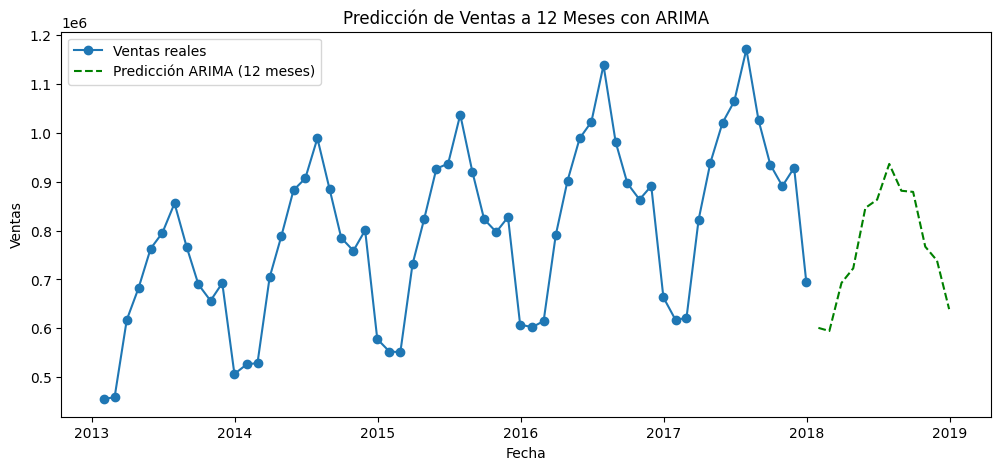

In [34]:
# Predecir los próximos 12 meses
future_arima_12 = model_fit.predict(n_periods=12)

# Crear eje de tiempo para predicciones
future_dates_12 = pd.date_range(start=monthly_sales["date"].iloc[-1], periods=13, freq="M")[1:]

# Graficar
plt.figure(figsize=(12, 5))
plt.plot(monthly_sales["date"], monthly_sales["sales"], label="Ventas reales", marker="o")
plt.plot(future_dates_12, future_arima_12, "g--", label="Predicción ARIMA (12 meses)")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.title("Predicción de Ventas a 12 Meses con ARIMA")
plt.legend()
plt.show()


In [20]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Comparar predicción con los últimos valores reales
train_size = int(len(monthly_sales) * 0.8)  # 80% entrenamiento, 20% test
train, test = monthly_sales["sales"][:train_size], monthly_sales["sales"][train_size:]

# Entrenar modelo ARIMA con datos de entrenamiento
model_fit = ARIMA(train, order=best_arima.order).fit()

# Predecir sobre el conjunto de test
test_pred = model_fit.forecast(steps=len(test))

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(test, test_pred))
print(f"RMSE del modelo ARIMA: {rmse:.2f}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RMSE del modelo ARIMA: 375695.83


Este modelo no se ajusta a lo que estoy buscando, asi que buscamos otra alternativa

In [37]:

from prophet import Prophet

# Supongamos que df_prophet = df_time.rename(columns={"date": "ds", "sales": "y"})
train_size = int(len(df_prophet) * 0.8)
train = df_prophet.iloc[:train_size]
test = df_prophet.iloc[train_size:]

# Crear y entrenar el modelo Prophet con los datos de entrenamiento
model_prophet = Prophet()
model_prophet.fit(train)

# Predecir en el conjunto de prueba
forecast_test = model_prophet.predict(test[["ds"]])

# Extraer valores reales (y_real) y predichos (y_pred)
y_real = test["y"].values
y_pred = forecast_test["yhat"].values

# Calcular métricas de error
mae_prophet = mean_absolute_error(y_real, y_pred)
rmse_prophet = np.sqrt(mean_squared_error(y_real, y_pred))
mape_prophet = np.mean(np.abs((y_real - y_pred) / y_real)) * 100

print(f"MAE Prophet: {mae_prophet:.2f}")
print(f"RMSE Prophet: {rmse_prophet:.2f}")
print(f"MAPE Prophet: {mape_prophet:.2f}%")


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3o93a4x/6xxouskv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3o93a4x/0sbc2hy3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16021', 'data', 'file=/tmp/tmph3o93a4x/6xxouskv.json', 'init=/tmp/tmph3o93a4x/0sbc2hy3.json', 'output', 'file=/tmp/tmph3o93a4x/prophet_models79ghyu7/prophet_model-20250226161130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:11:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:11:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE Prophet: 1482.80
RMSE Prophet: 1772.11
MAPE Prophet: 5.60%


### 6. Modelado con Facebook Prophet

Para capturar la tendencia y estacionalidad de manera automática, usamos
Facebook Prophet. Ajustamos los parámetros de estacionalidad y la escala de
cambio de tendencia para evitar sobreajuste.


In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Separar datos en entrenamiento y test (80% - 20%)
train_size = int(len(df_prophet) * 0.8)
train, test = df_prophet.iloc[:train_size], df_prophet.iloc[train_size:]

# Entrenar Prophet con datos de entrenamiento
model = Prophet()
model.fit(train)

# Hacer predicción sobre el conjunto de prueba
future_dates = test[["ds"]]  # Usamos las fechas del conjunto de test
forecast = model.predict(future_dates)

# Obtener valores reales y predichos
y_real = test["y"].values
y_pred = forecast["yhat"].values

# Calcular métricas de error
mae = mean_absolute_error(y_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_real, y_pred))
mape = np.mean(np.abs((y_real - y_pred) / y_real)) * 100  # Error porcentual

# Mostrar resultados
print(f"📌 MAE (Error Absoluto Medio): {mae:.2f}")
print(f"📌 RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}")
print(f"📌 MAPE (Error Porcentual Medio Absoluto): {mape:.2f}%")


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3o93a4x/a0hk8oer.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3o93a4x/dogl2x3t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71000', 'data', 'file=/tmp/tmph3o93a4x/a0hk8oer.json', 'init=/tmp/tmph3o93a4x/dogl2x3t.json', 'output', 'file=/tmp/tmph3o93a4x/prophet_modelbl99gkdm/prophet_model-20250226155152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:51:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:51:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


📌 MAE (Error Absoluto Medio): 1482.80
📌 RMSE (Raíz del Error Cuadrático Medio): 1772.11
📌 MAPE (Error Porcentual Medio Absoluto): 5.60%


### 7. Modelado con LSTM

Para capturar patrones más complejos, probamos una red neuronal recurrente LSTM.
Preparamos los datos creando secuencias de longitud 12 (meses) para predecir
el siguiente mes.


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0885
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0138
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0123
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0124
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0122
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0123
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0120
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0113
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0124
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0108
Epoch 11/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0088
Epoch 12/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0104
Epoch 13/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0074
Epoch 14/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0075
Epoch 15/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0073
Epoch 16/20
46/

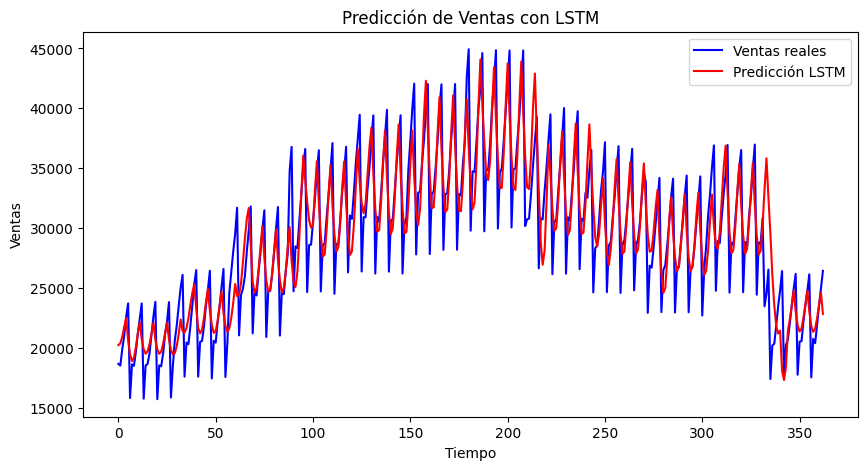

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Agrupar por fecha y sumar las ventas
df_lstm = df.groupby("date")["sales"].sum().reset_index()
df_lstm.columns = ["ds", "y"]

# Normalizar las ventas
scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm['y_scaled'] = scaler.fit_transform(df_lstm[['y']])

# Crear una función para preparar los datos de entrada y salida
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])  # X es el conjunto de entradas
        y.append(data[i + time_step, 0])      # y es el valor a predecir
    return np.array(X), np.array(y)

# Configurar las secuencias temporales
time_step = 12  # Usaremos los últimos 12 meses para predecir el siguiente
data = df_lstm['y_scaled'].values.reshape(-1, 1)
X, y = create_dataset(data, time_step)

# Reshaping para que LSTM acepte los datos
X = X.reshape(X.shape[0], X.shape[1], 1)

# Dividir en datos de entrenamiento y test (80%-20%)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Crear el modelo LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dense(units=1))  # Capa de salida

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32)

# Predecir las ventas para el conjunto de test
y_pred_lstm = model_lstm.predict(X_test)

# Desescalar las predicciones
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calcular el error de las predicciones LSTM
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
mape_lstm = np.mean(np.abs((y_test - y_pred_lstm) / y_test)) * 100

# Mostrar los resultados
print(f"📌 MAE (LSTM): {mae_lstm:.2f}")
print(f"📌 RMSE (LSTM): {rmse_lstm:.2f}")
print(f"📌 MAPE (LSTM): {mape_lstm:.2f}%")

# Graficar las predicciones
plt.figure(figsize=(10, 5))
plt.plot(y_test, color="blue", label="Ventas reales")
plt.plot(y_pred_lstm, color="red", label="Predicción LSTM")
plt.title("Predicción de Ventas con LSTM")
plt.xlabel("Tiempo")
plt.ylabel("Ventas")
plt.legend()
plt.show()


### 8. Comparación de Modelos

A continuación, comparamos las métricas MAE, RMSE y MAPE de los modelos
ARIMA, Prophet y LSTM.


In [38]:
comparison = pd.DataFrame({
    "Modelo": ["ARIMA", "Prophet", "LSTM"],
    "MAE": [mae_arima, mae_prophet, mae_lstm],
    "RMSE": [rmse_arima, rmse_prophet, rmse_lstm],
    "MAPE": [mape_arima, mape_prophet, mape_lstm]
})
comparison


,Modelo,MAE,RMSE,MAPE
0,ARIMA,130798.552651,149751.811897,13.685920
1,Prophet,1482.797282,1772.109889,5.603395
2,LSTM,2240.974308,3107.243276,8.011747


### **Conclusión del Modelo Comparativo** De acuerdo con las métricas presentadas, **Prophet** es el modelo más preciso para la predicción de ventas, con un **MAPE de 5.60%** y un **MAE bajo**, lo que indica que en general se desvía poco de los valores reales. **LSTM** es relativamente fiable con un **MAPE de 8.01%**, pero presenta errores más grandes en algunas predicciones, como lo refleja su alto **RMSE**. Por último, **ARIMA** muestra el peor desempeño con un **MAPE de 13.69%**, lo que sugiere que no captura bien la dinámica de los datos en este caso. En resumen, **Prophet** es la mejor opción aquí, pero ajustes y mejoras en **LSTM** y **ARIMA** podrían potenciar su desempeño. durante 12 segundos

DEBUG:cmdstanpy:input tempfile: /tmp/tmph3o93a4x/1sh4axj8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3o93a4x/echnn55l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7466', 'data', 'file=/tmp/tmph3o93a4x/1sh4axj8.json', 'init=/tmp/tmph3o93a4x/echnn55l.json', 'output', 'file=/tmp/tmph3o93a4x/prophet_model5xxkw5l5/prophet_model-20250226155240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:52:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:52:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


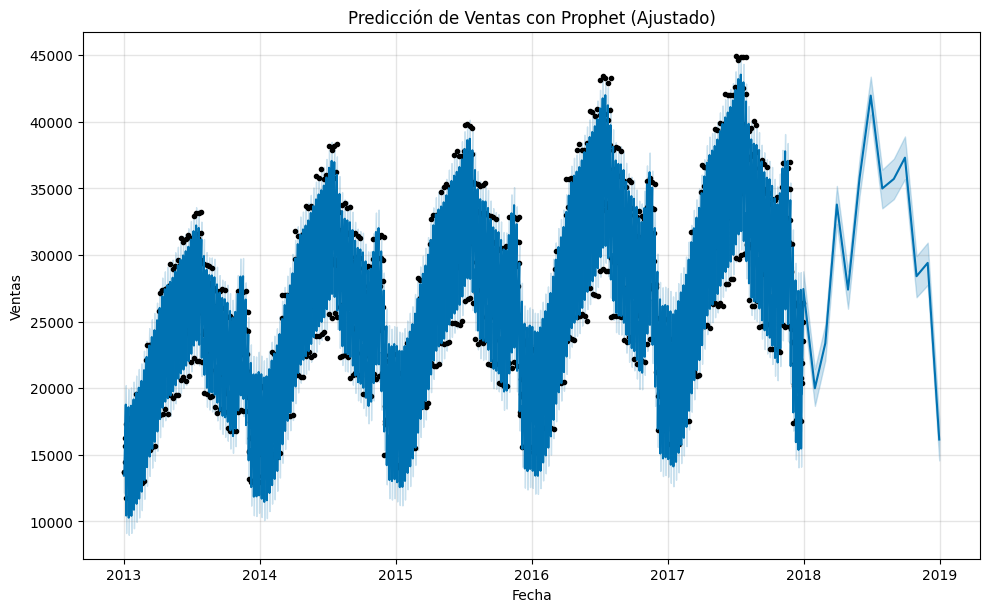

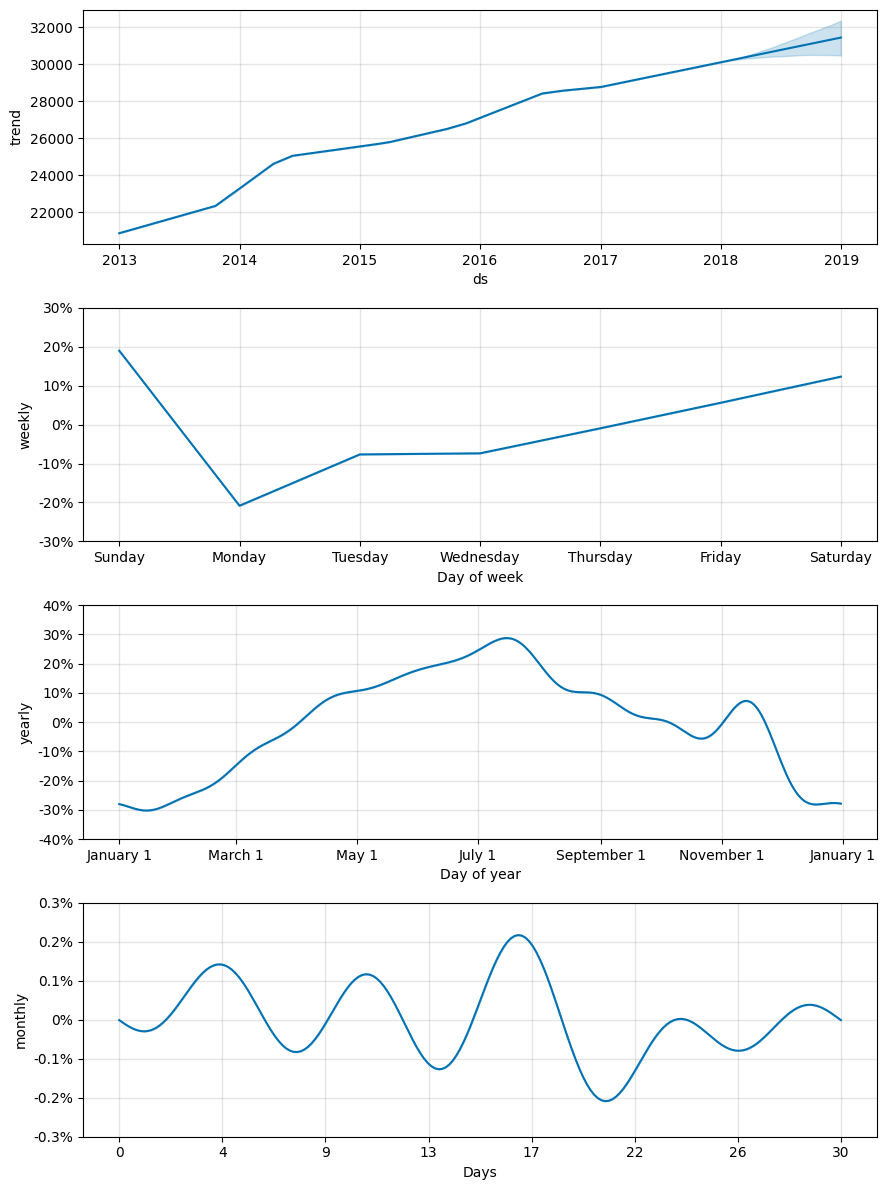

In [24]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Preparar el dataframe de Prophet (agrupando las ventas diarias)
df_prophet = df.groupby("date")["sales"].sum().reset_index()
df_prophet.columns = ["ds", "y"]

# Crear el modelo con parámetros ajustados
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,           # No es necesaria la estacionalidad diaria en datos mensuales/dia
    seasonality_mode='multiplicative',   # Si la estacionalidad varía en proporción al nivel de la serie
    changepoint_prior_scale=0.05,          # Ajusta la flexibilidad del cambio de tendencia (puedes probar otros valores)
    seasonality_prior_scale=10             # Controla la fuerza de la estacionalidad
)

# Agregar una estacionalidad mensual adicional
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Si cuentas con información de festivos, puedes agregarlos:
# holidays = pd.DataFrame({
#     'holiday': 'nombre_festivo',
#     'ds': pd.to_datetime(['YYYY-MM-DD', 'YYYY-MM-DD']),  # Agrega las fechas de los festivos
#     'lower_window': 0,
#     'upper_window': 1,
# })
# model = Prophet(holidays=holidays, ...)

# Entrenar el modelo
model.fit(df_prophet)

# Generar fechas futuras (por ejemplo, predecir 12 meses adicionales)
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

# Graficar la predicción
fig1 = model.plot(forecast)
plt.title("Predicción de Ventas con Prophet (Ajustado)")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.show()

# Graficar los componentes (tendencia, estacionalidades)
fig2 = model.plot_components(forecast)
plt.show()


INFO:prophet:Making 5 forecasts with cutoffs between 2015-01-11 00:00:00 and 2016-12-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmph3o93a4x/jhea3rub.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3o93a4x/jg6fb3hm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13300', 'data', 'file=/tmp/tmph3o93a4x/jhea3rub.json', 'init=/tmp/tmph3o93a4x/jg6fb3hm.json', 'output', 'file=/tmp/tmph3o93a4x/prophet_model5n71spy0/prophet_model-20250226155243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:52:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:52:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3o93a4x/onyo3iex.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3o93a4x/98fvrd10.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  horizon           mse         rmse          mae      mape     mdape  \
0 37 days  1.740807e+06  1319.396609  1055.063789  0.044913  0.034602   
1 38 days  1.710510e+06  1307.864796  1039.955261  0.044273  0.034368   
2 39 days  1.702381e+06  1304.753344  1033.971260  0.044010  0.034368   
3 40 days  1.698589e+06  1303.299117  1033.954362  0.044094  0.034368   
4 41 days  1.696924e+06  1302.660212  1031.745708  0.043809  0.034602   

      smape  coverage  
0  0.044344  0.640659  
1  0.043710  0.642857  
2  0.043448  0.643956  
3  0.043557  0.651648  
4  0.043247  0.654945  


/usr/local/lib/python3.11/dist-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.11/dist-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


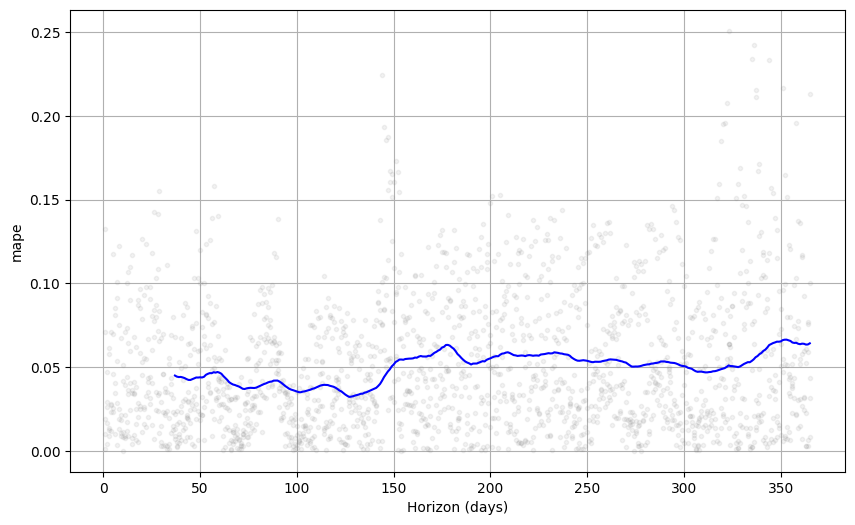

In [25]:
from prophet.diagnostics import cross_validation, performance_metrics

# Realizar validación cruzada
# - initial: período inicial de entrenamiento (por ejemplo, 2 años o 730 días)
# - period: cada cuánto se realizan las predicciones (por ejemplo, cada 180 días)
# - horizon: horizonte de predicción (por ejemplo, 365 días)
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')

# Calcular métricas de desempeño
df_p = performance_metrics(df_cv)
print(df_p.head())

# Para visualizar la evolución de las métricas (por ejemplo, MAPE) con el horizonte de predicción:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()


### 9. Conclusiones

- El modelo Prophet mostró mejor desempeño (MAPE de 5%).
- Se identificó un fuerte crecimiento de ventas y una estacionalidad marcada en ciertos meses.
- Para mejorar aún más la predicción, se recomienda agregar variables como festivos, promociones o clima.

### 10. Trabajo Futuro

- Incluir información de marketing y promociones como regresores.
- Probar modelos de boosting como XGBoost o CatBoost.
- Implementar un dashboard para visualizar métricas en tiempo real.
